<a href="https://colab.research.google.com/github/bi-horn/CNN_Medical_Image_Classification/blob/main/CNN_XRay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torchvision
print(torchvision.__version__)

0.16.0+cu121


In [2]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os, time, random, torch, warnings
import numpy as np
from PIL import Image
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import precision_score, recall_score, f1_score

warnings.simplefilter("ignore")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cpu')

Defining functions

Starting with model

In [7]:
data_path = '/content/drive/My Drive/XRay/'

sample_ratio = 0.4
batch_size = 96
num_epochs = 20

In [5]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [19]:
#load training, test and validation datasets and preprocess the images
%run '/content/drive/My Drive/Colab Notebooks/helper_functions.ipynb'
dataset, train_loader, train_indices, test_loader, test_indices, val_loader, val_indices = data_preprocess(data_path, sample_ratio)

Dataset ImageFolder
    Number of datapoints: 5855
    Root location: /content/drive/My Drive/XRay/data
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )


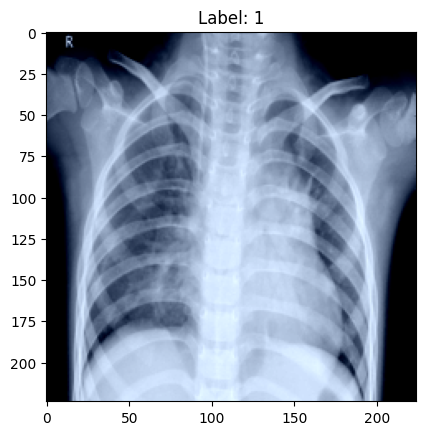

In [17]:
#View the dataset and print a XRay image to see if everything is correctly resized and transformed

print(dataset)

#Grab 1 image
# Get one batch of data from the train loader
for images, labels in train_loader:
    break  # Exit the loop after the first batch

# Convert Tensor to numpy array
image = images[0].numpy()
label = labels[0].item()

# Denormalize the image (if normalization was applied)
# Use the inverse of the normalization transform, e.g. if you used transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# you can denormalize by multiplying by 0.5 and then adding 0.5
image = image * 0.485 + 0.229

# Display the image
plt.imshow(np.transpose(image, (1, 2, 0)))
plt.title(f'Label: {label}')
plt.show()

In [8]:
#either use predefined model e.g. ResNet18 (Version 1) or self-defined simpler model (Version 2)

#Version 1:
# Define the ResNet18 model and set Pretraining to False to train model from scratch

model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained = False)
model.fc = nn.Linear(512, len(dataset.classes)) #replaces the fully connected layer (model.fc) with a new one that has the output size matching the number of classes in the dataset
#print(len(dataset.classes)) #= 2 NORMAL or PNEUMONIA
model.to(device)

# Define loss function as CrossEntropy and optimizer as Adam Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
#criterion and optimizer are inputs of the train function
losses, accuracies, v_accuracies, v_losses = train_model(model, criterion, optimizer, "ResNet18", num_epochs)




Downloading: "https://github.com/pytorch/vision/zipball/v0.9.0" to /root/.cache/torch/hub/v0.9.0.zip
Epoch 1/20: 100%|██████████| 18/18 [11:11<00:00, 37.28s/batch, Accuracy=0.865, Loss=0.0215, Precision=0.835, Recall=0.835, F1 Score=0.835]


VALIDATION: Accuracy: 0.7532 | Loss: 1.3364 | Recall: 0.5000 | Precision: 0.3766 | F-score: 0.4296



Epoch 2/20: 100%|██████████| 18/18 [08:58<00:00, 29.91s/batch, Accuracy=0.707, Loss=0.323, Precision=0.744, Recall=0.706, F1 Score=0.719]


VALIDATION: Accuracy: 0.5489 | Loss: 0.7472 | Recall: 0.6948 | Precision: 0.6691 | F-score: 0.5471



Epoch 3/20: 100%|██████████| 18/18 [08:55<00:00, 29.72s/batch, Accuracy=0.747, Loss=0.085, Precision=0.726, Recall=0.688, F1 Score=0.701]


VALIDATION: Accuracy: 0.8468 | Loss: 0.3565 | Recall: 0.8693 | Precision: 0.7989 | F-score: 0.8184



Epoch 4/20: 100%|██████████| 18/18 [09:09<00:00, 30.54s/batch, Accuracy=0.897, Loss=0.0131, Precision=0.767, Recall=0.733, F1 Score=0.746]


VALIDATION: Accuracy: 0.8511 | Loss: 0.4178 | Recall: 0.8895 | Precision: 0.8078 | F-score: 0.8268



Epoch 5/20: 100%|██████████| 18/18 [09:21<00:00, 31.17s/batch, Accuracy=0.901, Loss=0.245, Precision=0.792, Recall=0.762, F1 Score=0.774]


VALIDATION: Accuracy: 0.9021 | Loss: 0.2320 | Recall: 0.9118 | Precision: 0.8575 | F-score: 0.8783



Epoch 6/20: 100%|██████████| 18/18 [09:51<00:00, 32.89s/batch, Accuracy=0.912, Loss=0.0868, Precision=0.811, Recall=0.783, F1 Score=0.794]


VALIDATION: Accuracy: 0.8936 | Loss: 0.2889 | Recall: 0.7903 | Precision: 0.9257 | F-score: 0.8324



Epoch 7/20: 100%|██████████| 18/18 [08:59<00:00, 29.95s/batch, Accuracy=0.915, Loss=0.0236, Precision=0.824, Recall=0.798, F1 Score=0.809]


VALIDATION: Accuracy: 0.8723 | Loss: 0.3017 | Recall: 0.9037 | Precision: 0.8267 | F-score: 0.8486



Epoch 8/20: 100%|██████████| 18/18 [08:35<00:00, 28.66s/batch, Accuracy=0.914, Loss=0.0446, Precision=0.834, Recall=0.809, F1 Score=0.82]


VALIDATION: Accuracy: 0.9277 | Loss: 0.1924 | Recall: 0.9172 | Precision: 0.8953 | F-score: 0.9054



Epoch 9/20: 100%|██████████| 18/18 [08:36<00:00, 28.70s/batch, Accuracy=0.937, Loss=0.146, Precision=0.845, Recall=0.822, F1 Score=0.832]


VALIDATION: Accuracy: 0.9191 | Loss: 0.2362 | Recall: 0.8362 | Precision: 0.9515 | F-score: 0.8766



Epoch 10/20: 100%|██████████| 18/18 [08:29<00:00, 28.33s/batch, Accuracy=0.925, Loss=0.0116, Precision=0.852, Recall=0.83, F1 Score=0.839]


VALIDATION: Accuracy: 0.9362 | Loss: 0.1753 | Recall: 0.8939 | Precision: 0.9309 | F-score: 0.9104



Epoch 11/20: 100%|██████████| 18/18 [08:29<00:00, 28.32s/batch, Accuracy=0.947, Loss=0.0157, Precision=0.86, Recall=0.839, F1 Score=0.848]


VALIDATION: Accuracy: 0.9319 | Loss: 0.1732 | Recall: 0.8910 | Precision: 0.9219 | F-score: 0.9051



Epoch 12/20: 100%|██████████| 18/18 [08:23<00:00, 27.96s/batch, Accuracy=0.956, Loss=0.139, Precision=0.868, Recall=0.847, F1 Score=0.857]


VALIDATION: Accuracy: 0.8638 | Loss: 0.3270 | Recall: 0.9038 | Precision: 0.8205 | F-score: 0.8410



Epoch 13/20: 100%|██████████| 18/18 [08:28<00:00, 28.24s/batch, Accuracy=0.923, Loss=0.17, Precision=0.871, Recall=0.852, F1 Score=0.86]


VALIDATION: Accuracy: 0.8979 | Loss: 0.2199 | Recall: 0.9090 | Precision: 0.8524 | F-score: 0.8736



Epoch 14/20: 100%|██████████| 18/18 [08:37<00:00, 28.75s/batch, Accuracy=0.938, Loss=0.0559, Precision=0.875, Recall=0.857, F1 Score=0.865]


VALIDATION: Accuracy: 0.9404 | Loss: 0.1821 | Recall: 0.9373 | Precision: 0.9102 | F-score: 0.9225



Epoch 15/20: 100%|██████████| 18/18 [08:31<00:00, 28.44s/batch, Accuracy=0.965, Loss=0.0261, Precision=0.881, Recall=0.864, F1 Score=0.871]


VALIDATION: Accuracy: 0.9362 | Loss: 0.1930 | Recall: 0.8881 | Precision: 0.9371 | F-score: 0.9092



Epoch 16/20: 100%|██████████| 18/18 [08:59<00:00, 29.99s/batch, Accuracy=0.961, Loss=0.00568, Precision=0.885, Recall=0.869, F1 Score=0.877]


VALIDATION: Accuracy: 0.8383 | Loss: 0.3841 | Recall: 0.8869 | Precision: 0.7996 | F-score: 0.8153



Epoch 17/20: 100%|██████████| 18/18 [08:39<00:00, 28.88s/batch, Accuracy=0.951, Loss=0.00778, Precision=0.889, Recall=0.873, F1 Score=0.88]


VALIDATION: Accuracy: 0.9319 | Loss: 0.1506 | Recall: 0.8968 | Precision: 0.9168 | F-score: 0.9062



Epoch 18/20: 100%|██████████| 18/18 [08:36<00:00, 28.68s/batch, Accuracy=0.974, Loss=0.00163, Precision=0.893, Recall=0.878, F1 Score=0.885]


VALIDATION: Accuracy: 0.9447 | Loss: 0.1470 | Recall: 0.9285 | Precision: 0.9236 | F-score: 0.9260



Epoch 19/20: 100%|██████████| 18/18 [08:29<00:00, 28.32s/batch, Accuracy=0.976, Loss=0.0177, Precision=0.898, Recall=0.883, F1 Score=0.89]


VALIDATION: Accuracy: 0.9404 | Loss: 0.2005 | Recall: 0.8851 | Precision: 0.9547 | F-score: 0.9136



Epoch 20/20: 100%|██████████| 18/18 [08:25<00:00, 28.10s/batch, Accuracy=0.969, Loss=0.00435, Precision=0.901, Recall=0.887, F1 Score=0.894]


VALIDATION: Accuracy: 0.9404 | Loss: 0.1852 | Recall: 0.8851 | Precision: 0.9547 | F-score: 0.9136



In [30]:
#Version 2:
model = ConvolutionalNetwork()
model.to(device)

# Define loss function as CrossEntropy and optimizer as Adam Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

losses, accuracies, v_accuracies, v_losses = train_model(model, criterion, optimizer, "Simple_model", num_epochs)

Epoch 1/2: 100%|██████████| 18/18 [02:10<00:00,  7.25s/batch, Accuracy=0.719, Loss=0.0716, Precision=0.639, Recall=0.559, F1 Score=0.548]


VALIDATION: Accuracy: 0.8638 | Loss: 0.3445 | Recall: 0.7415 | Precision: 0.8817 | F-score: 0.7801



Epoch 2/2: 100%|██████████| 18/18 [01:12<00:00,  4.04s/batch, Accuracy=0.879, Loss=0.0764, Precision=0.792, Recall=0.687, F1 Score=0.709]


VALIDATION: Accuracy: 0.8809 | Loss: 0.2743 | Recall: 0.8803 | Precision: 0.8327 | F-score: 0.8511



In [10]:
#Save pre-trained model to file
model_name = "ResNet18"
torch.save(model.state_dict(), "{}{}_pretrained.pth".format(data_path, model_name))

 ## Load the saved model

In [16]:
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(512, len(dataset.classes))
#or
#model = ConvolutionalNeuralNetwork()
model.to(device)

model.load_state_dict(torch.load("{}{}_pretrained.pth".format(data_path, model_name)))

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [48]:
# Load the saved model parameters
# Assuming 'data_path' contains the path to your model
#model_path = "{}resnet18.pth".format(data_path)

def load_metrics(model_name, data_path):
    # Load the saved metrics
    train_loss = np.load("{}{}_train_loss.npy".format(data_path, model_name))
    train_accuracy = np.load("{}{}_train_accuracy.npy".format(data_path, model_name))
    val_loss = np.load("{}{}_validation_loss.npy".format(data_path, model_name))
    val_accuracy = np.load("{}{}_validation_accuracy.npy".format(data_path, model_name))

    return train_loss, train_accuracy, val_loss, val_accuracy

# Example usage:
model_name = "ResNet18"  # Update this with your actual model name

losses, accuracies, v_losses, v_accuracies = load_metrics(model_name, data_path)

print(train_loss)

[0.01414993 0.01313216 0.01340105 0.01013627 0.01071091 0.0083462
 0.01113799 0.00718139 0.00092411 0.00175681 0.00137394 0.00602131
 0.00382181 0.00315026 0.00211306 0.00324434 0.00172667 0.00064016
 0.00051097 0.00506085]


In [28]:
%run '/content/drive/My Drive/Colab Notebooks/helper_functions.ipynb'

##Plot the Model Accuracy and Loss on Training and Validation Sets

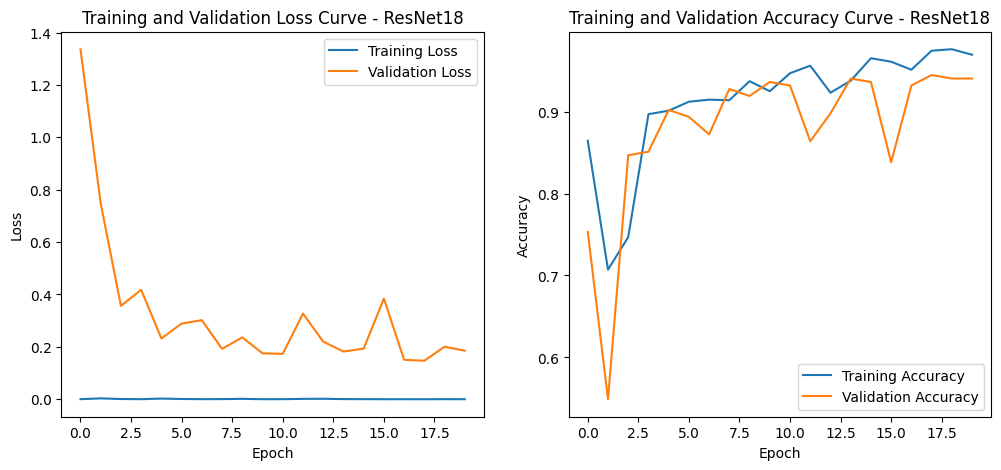

In [20]:
model_name = "ResNet18"
plot_model_curves(losses, accuracies, v_accuracies, v_losses, data_path, model_name)


##Plot the Confusion Matrix on Test Set

TEST: Accuracy: 0.9274 | Loss: 0.1657 | Recall: 0.8781 | Precision: 0.9430 | F-score: 0.9037



<Figure size 800x800 with 0 Axes>

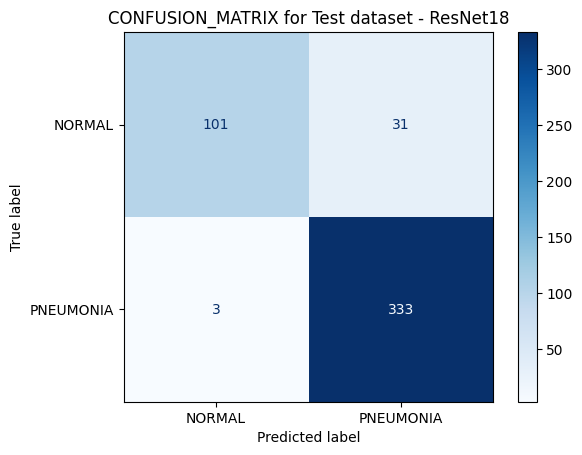

In [24]:
test_accuracy, test_loss, test_true, test_pred = evaluate_model(model, test_loader, test_indices, 'TEST', criterion, data_path, model_name)

plot_confusion_mat(test_true, test_pred, model_name, test_loader, "Test", data_path)

##Plot the Receiver-Operating Curve (ROC) for detecting pneumonia versus normal

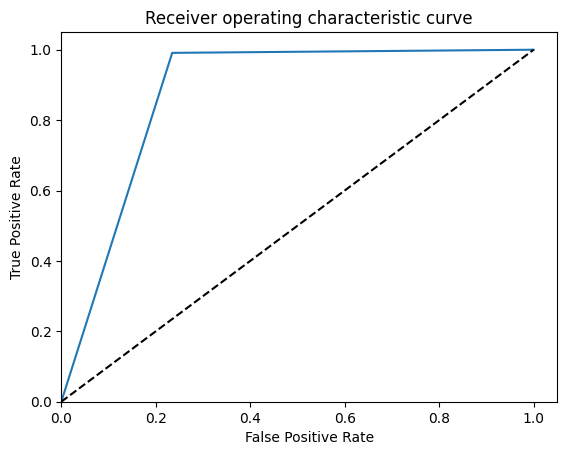

0.8781114718614719

In [29]:
generate_roc(test_true, test_pred, data_path, model_name, pos_label = 1)

##Hyperparameter tuning (here learning rate tuning)

In [ ]:

model_name = "ResNet18"
#or
#model_name = "SimpleModel"

learning_rate = [0.005, 0.0001, 0.0005, 0.00001]

for i in learning_rate:

  if model_name == "ResNet18":
        model = models.resnet18(pretrained=False)
        model.fc = nn.Linear(512, len(dataset.classes))
  elif model_name == "SimpleModel":
        model = ConvolutionalNetwork()  # Assuming ConvolutionalNetwork is defined elsewhere
  else:
        print("Error: Unknown model name")

  model.to(device)  # Assuming device is defined earlier

  print("Training Model {} with Learning Rate = {}, Batch Size = {}, Number of Epochs = {}".format(learning_rate.index(i)+1, i, batch_size, num_epochs))
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr = i)

  losses, accuracies, v_accuracies, v_losses = train_model(model, criterion, optimizer, model_name, num_epochs)
  #Save Model
  torch.save(model.state_dict(), "{}{}_{}.pth". format(data_path, i, model_name))
  #Plotting the Loss and Accuracy Curves
  plot_model_curves(losses, accuracies, v_accuracies, v_losses)
  #Evaluate Model on Test Set
  evaluate_model(model, test_loader, test_indices, 'TEST', criterion, data_path, model_name)


Training Model 1 with Learning Rate = 0.005, Batch Size = 50, Number of Epochs = 10


Epoch 1/10: 100%|██████████| 8/8 [00:10<00:00,  1.35s/batch, Accuracy=0.508, Loss=7.76, Precision=0.514, Recall=0.513, F1 Score=0.506]


VALIDATION: Accuracy: 0.4286 | Loss: 0.7044 | Recall: 0.4026 | Precision: 0.3021 | F-score: 0.3243



Epoch 2/10:   0%|          | 0/8 [00:03<?, ?batch/s]


KeyboardInterrupt: 